In [ ]:
#Taylor Stevenson
#Assignment 8

In [1]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [3]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

In [4]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.losses import CategoricalCrossentropy


In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

os.getcwd()
%cd /content/gdrive/My Drive/Colab Notebooks/ML_Assignment8/
!pwd
!ls

work_dir = "/content/gdrive/My Drive/Colab Notebooks/ML_Assignment8/"

df_train = pd.read_csv(work_dir+'train.csv')
df_test = pd.read_csv(work_dir+'test.csv')
data_root = "../input/"
img_folder = data_root + 'images/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/Colab Notebooks/ML_Assignment8
/content/gdrive/My Drive/Colab Notebooks/ML_Assignment8
Assignment8_Stevenson.ipynb  images  test.csv  train.csv


In [6]:
# Train info
print(f'train shape: {df_train.shape}')
print(df_train.info())

train shape: (990, 194)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 990 entries, 0 to 989
Columns: 194 entries, id to texture64
dtypes: float64(192), int64(1), object(1)
memory usage: 1.5+ MB
None


In [7]:
# Test info
print(f'test shape: {df_test.shape}')
print(df_test.info())

test shape: (594, 193)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594 entries, 0 to 593
Columns: 193 entries, id to texture64
dtypes: float64(192), int64(1)
memory usage: 895.8 KB
None


In [8]:
# View columns
df_train.columns

Index(['id', 'species', 'margin1', 'margin2', 'margin3', 'margin4', 'margin5',
       'margin6', 'margin7', 'margin8',
       ...
       'texture55', 'texture56', 'texture57', 'texture58', 'texture59',
       'texture60', 'texture61', 'texture62', 'texture63', 'texture64'],
      dtype='object', length=194)

In [9]:
#Reducing Training set size to 84
#Grouped to only unique values, just a lsit of unique values
df = df_train[['id','species']]
species = df.species.unique()
#print(df.species.nunique())  #99

species[:60]
print(df.species.nunique())

#Matched the size of the test set
df_cut = df[df.species.isin(species[:60])]
df_cut['species'].nunique()

99


60

In [10]:
df_cut['species'].nunique()

60

In [11]:
train, test = train_test_split(df_cut, stratify = df_cut['species'], test_size = 0.2)
print("sample training Image names with labels of species\n")
print(train.head())
print("sample testing Image names with labels of species\n")
print(test.head())

sample training Image names with labels of species

       id               species
850  1360          Ilex_Cornuta
544   870        Quercus_Texana
283   464   Arundinaria_Simonii
687  1096     Alnus_Sieboldiana
81    143  Callicarpa_Bodinieri
sample testing Image names with labels of species

       id                      species
685  1094          Cercis_Siliquastrum
30     48      Liriodendron_Tulipifera
33     54  Rhododendron_x_Russellianum
711  1144              Quercus_Phellos
730  1172            Prunus_X_Shmittii


In [12]:
train['species'].nunique()
test['species'].nunique()

60

In [13]:
# data generator for training images
image_data = ImageDataGenerator(rescale=1./255, validation_split=0.2)
# data generator for validation images
test_img_data = ImageDataGenerator(rescale=1./255)

In [14]:
#print(train.dtype)

train = train.astype('str')
test = test.astype('str')

train['id'] = train['id'] + ".jpg"
test['id'] = test['id'] + ".jpg"



In [15]:
"""Data generator that generates training, validation, testing images into target size"""
# Directory of Images
path = './images/'


# Extracting images from the path and resizing them to (256,256) size. The same is done for training, valiation,
# testing images.
train_data = image_data.flow_from_dataframe(train,
                                           directory=path,
                                            x_col='id',
                                            y_col='species',
                                            class_mode='categorical',
                                            target_size=(256,256),
                                            color_mode='rgb',
                                            batch_size=64,
                                            shuffle=True,
                                            seed=3,
                                            interpolation='nearest',
                                            subset='training',
                                            validate_filenames=True)

validation_data = image_data.flow_from_dataframe(train,
                                           directory=path,
                                           x_col='id',
                                           y_col='species',
                                           class_mode='categorical',
                                           target_size=(256,256),
                                           color_mode='rgb',
                                           batch_size=64,
                                           shuffle=True,
                                           seed=3,
                                           interpolation='nearest',
                                                 subset='validation',
                                           validate_filenames=True)
 
test_data = test_img_data.flow_from_dataframe(test,
                                           directory=path,
                                           x_col='id',
                                           y_col='species',
                                           class_mode='categorical',
                                           target_size=(256,256),
                                           color_mode='rgb',
                                           batch_size=64,
                                           shuffle=True,
                                           seed=3,
                                           interpolation='nearest',
                                           validate_filenames=True)

Found 384 validated image filenames belonging to 60 classes.
Found 96 validated image filenames belonging to 60 classes.
Found 120 validated image filenames belonging to 60 classes.


In [ ]:
print(test_data.next())
test_data.next()[0].shape

In [17]:
print(test['id'])

685    1094.jpg
30       48.jpg
33       54.jpg
711    1144.jpg
730    1172.jpg
         ...   
910    1463.jpg
211     358.jpg
5         8.jpg
66      115.jpg
941    1512.jpg
Name: id, Length: 120, dtype: object


In [18]:
"""Displaying sample of data generated by ImageDataGenerator"""
print("Sample data for an image: \n", train_data.next()[0][0])
print("\nImages by data generator shape: ", train_data.next()[0].shape)

Sample data for an image: 
 [[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]]

Images by data generator shape:  (64, 256, 256, 3)


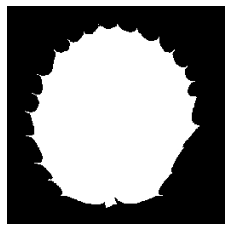

In [19]:
#Sample Image
plt.axis('off')
plt.imshow(train_data.next()[0][0])

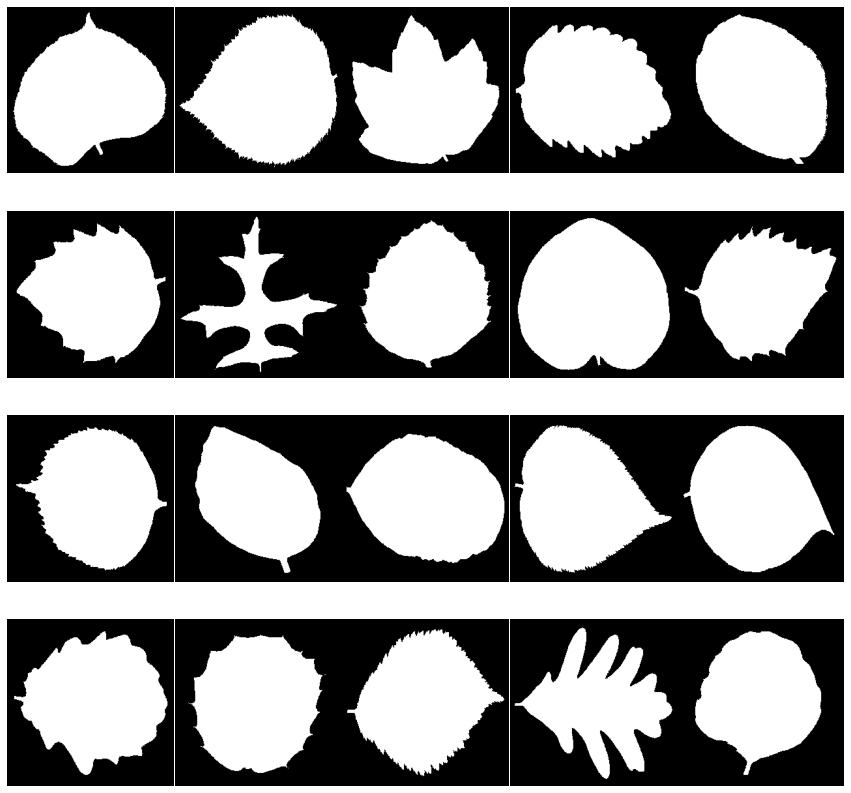

In [20]:
#More sample images
plt.figure(figsize=(15,15))
for i in range(20):
    plt.subplot(4,5,i+1)
    plt.axis('off')
    plt.imshow(train_data.next()[0][0])
plt.subplots_adjust(wspace=0.005, hspace=0.005)

In [21]:
df_train.species.nunique(dropna = True)

99

In [22]:
# Sequential model
network = models.Sequential()

# First Convolutional layer with (3,3) matrix size, same padding refers to add additional columns or rows to align
# with the filter and a maxpooling layers which takes maximum value in the (3,3) pixel value matrix.
network.add(layers.Conv2D(10,(3,3), padding='same', activation='relu', input_shape = (256,256,3)))
network.add(layers.MaxPool2D((3,3)))

# Second convolutional layer same as above but this one produces 512 feature maps unlike 10 above.
network.add(layers.Conv2D(512,(3,3), padding='same', activation='relu'))
network.add(layers.MaxPool2D((3,3)))

# Third convolutional layer same as above but this one produces 256 feature maps unlike 512 above.
network.add(layers.Conv2D(256,(3,3), padding='same', activation='relu'))
network.add(layers.MaxPool2D((3,3)))

# Fourth convolutional layer same as above but this one produces 128 feature maps unlike 256 above.
network.add(layers.Conv2D(128,(3,3), padding='same', activation='relu'))
network.add(layers.MaxPool2D((3,3)))

# Flatten layer
network.add(layers.Flatten())

# Dropout layer of 25%
network.add(layers.Dropout(0.25))

# Dense layer of 512 neurons with L2 regularization and ReLU activation function
network.add(layers.Dense(512, kernel_regularizer = regularizers.l2(0.01), activation='relu'))

# Dropout layer of 20% 
network.add(layers.Dropout(0.2))

# Dense Layer of 512 neurons with L2 regularization and ReLU activation function
network.add(layers.Dense(512, kernel_regularizer = regularizers.l2(0.01), activation='relu'))

# Final Dense Layer with number of neurons same as number of classes of classification and 'softmax' as the 
# activation function
# softmax is useful because it converts the output layer into what is essentially a probability distribution.
network.add(layers.Dense(60, activation='softmax'))

In [23]:
#Compiling the network
# The network has to be compiled before using it for fitting the data.
network.compile(optimizer='adam', 
                loss=CategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [24]:
#A summary of layers in the neural network
network.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 10)      280       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 85, 85, 10)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 85, 85, 512)       46592     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 28, 28, 512)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 256)       1179904   
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 9, 9, 256)        0

In [25]:
#Fitting the model
# the number of steps in each training process or epoch. It is determined by remainder of train_data divided by
# batch size and the same for validation steps
train_steps = train_data.n//train_data.batch_size
val_steps = validation_data.n//validation_data.batch_size

# epochs define the number of times to go through the entire training data.
epochs = 10
train_results = network.fit(train_data, 
                              steps_per_epoch=train_steps, 
                              epochs=epochs,
                              validation_data=validation_data,
                              validation_steps=val_steps,
                              verbose=2)

Epoch 1/10
6/6 - 5s - loss: 15.1544 - accuracy: 0.0104 - val_loss: 13.6415 - val_accuracy: 0.0000e+00 - 5s/epoch - 838ms/step
Epoch 2/10
6/6 - 2s - loss: 12.6536 - accuracy: 0.0156 - val_loss: 11.4688 - val_accuracy: 0.0000e+00 - 2s/epoch - 300ms/step
Epoch 3/10
6/6 - 2s - loss: 10.5935 - accuracy: 0.0443 - val_loss: 9.7472 - val_accuracy: 0.0000e+00 - 2s/epoch - 297ms/step
Epoch 4/10
6/6 - 2s - loss: 8.9383 - accuracy: 0.0260 - val_loss: 8.4099 - val_accuracy: 0.0000e+00 - 2s/epoch - 288ms/step
Epoch 5/10
6/6 - 2s - loss: 7.5886 - accuracy: 0.0495 - val_loss: 7.1901 - val_accuracy: 0.0000e+00 - 2s/epoch - 307ms/step
Epoch 6/10
6/6 - 2s - loss: 6.4077 - accuracy: 0.0729 - val_loss: 6.1157 - val_accuracy: 0.0938 - 2s/epoch - 300ms/step
Epoch 7/10
6/6 - 2s - loss: 5.3715 - accuracy: 0.1667 - val_loss: 5.0434 - val_accuracy: 0.2344 - 2s/epoch - 301ms/step
Epoch 8/10
6/6 - 2s - loss: 4.4279 - accuracy: 0.3203 - val_loss: 4.4206 - val_accuracy: 0.2344 - 2s/epoch - 305ms/step
Epoch 9/10
6/6 

In [26]:
def plot_train_results(train_results):
    """This function displays the training results"""
    acc = train_results.history['accuracy']
    val_acc = train_results.history['val_accuracy']

    loss = train_results.history['loss']
    val_loss = train_results.history['val_loss']
    """Using matplotlib to show results"""
    """Below code displays (Training and Validation Accuracy) Vs number of epochs"""

    plt.figure(figsize=(12, 12))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')
    """Below code displays (Training and Validation Loss) Vs number of epochs"""

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Loss')
    plt.ylim([0,max(plt.ylim())])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

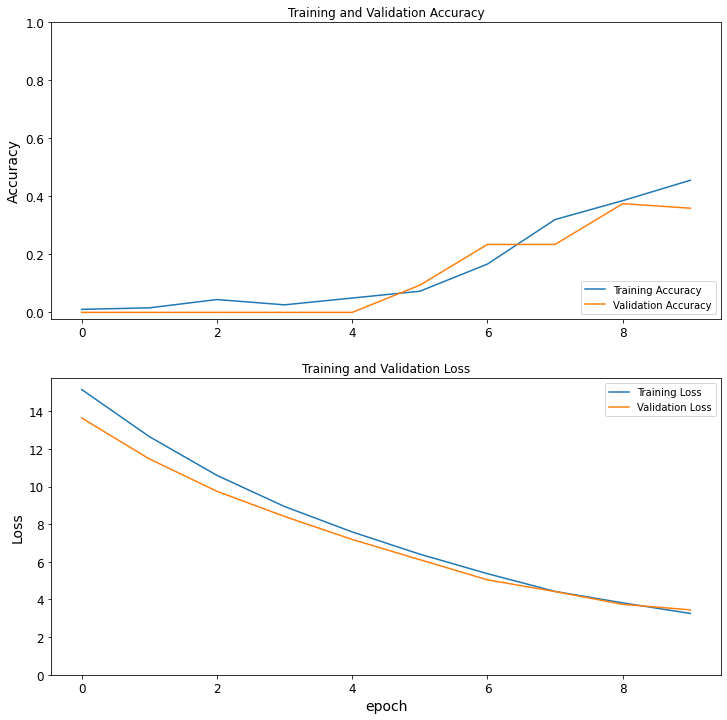

In [27]:
plot_train_results(train_results)

In [28]:
def test_results(model, testing_data):
    """ This function is to display the test results of the the CNN model
"""
    test_loss, test_acc = model.evaluate(testing_data, verbose=2)
    print('Test loss: {loss:.2f}'.format(loss=test_loss))
    print('Test accuracy: {acc:.2f}%'.format(acc=test_acc*100))
    return

In [29]:
test_results(network, test_data)

2/2 - 1s - loss: 3.0291 - accuracy: 0.5417 - 709ms/epoch - 355ms/step
Test loss: 3.03
Test accuracy: 54.17%


In [38]:
# data generator for training images
image_data_final = ImageDataGenerator(rescale=1./255)

df_test['id'] = df_test['id'].astype('str')

df_test['id'] = df_test['id'] + ".jpg"


test_data_final = image_data_final.flow_from_dataframe(df_test,
                                           directory=path,
                                           x_col='id',
                                           y_col = df_train['species'],
                                           target_size=(256,256),
                                           color_mode='rgb',
                                           batch_size=64,
                                           shuffle=True,
                                           seed=3,
                                           interpolation='nearest',
                                           validate_filenames=True)

KeyError: ignored

In [30]:
network.predict(test_data_final)

ValueError: ignored

In [29]:
#ROC Curve
#Was not able to complete because I did not output a prediciton. 

In [ ]:
#Precision/Recall Curve
#Was not able to complete because I did not output a prediction